In [1]:
import os
import re
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import scgen
import scanpy as sc
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/s

In [2]:
import logging

In [3]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [4]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [100]:
run_name = 'zheng_68k_unsorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Filtered_68K_PBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 10000
epochs = 5
batch_size = 64

In [4]:
run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [5]:
%%time
# expression_df.to_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

CPU times: user 9.74 s, sys: 7.81 s, total: 17.6 s
Wall time: 17.6 s


Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

CPU times: user 6min 18s, sys: 18 s, total: 6min 36s
Wall time: 6min 34s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
expression_df = expression_df.set_index(sample_column)
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,cell_id,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
0,HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
1,HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
2,HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
3,HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
4,HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...,...
49083,HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
49084,HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49085,HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49086,HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [7]:
label_df = label_df.set_index('cell_id')
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
cell_id,,,,,,,,
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes


In [8]:
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [62]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [63]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('BR_Malignant', 10137),
 ('Fibroblasts', 8305),
 ('CD4+ T-cells', 8001),
 ('CD8+ T-cells', 7080),
 ('Macrophages', 3585),
 ('B-cells', 3001),
 ('Endothelial cells', 2883),
 ('NK cells', 2053),
 ('Tregs', 1523),
 ('Plasma cells', 1445),
 ('Unknown', 808),
 ('Mast cells', 161),
 ('DC', 106)]

In [64]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [65]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [66]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


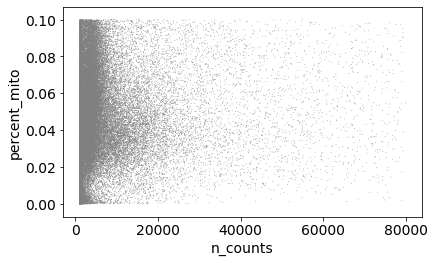

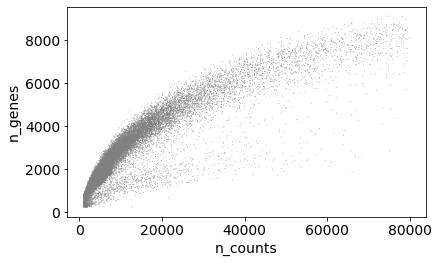

In [67]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [68]:
sc.pp.normalize_total(adata, target_sum=1e6)


In [69]:
sc.pp.log1p(adata)


In [70]:
adata.raw = adata

In [71]:
adata

AnnData object with n_obs × n_vars = 48280 × 26912 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [72]:
adata.X

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 4.590193],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

In [73]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10., min_disp=0.2)


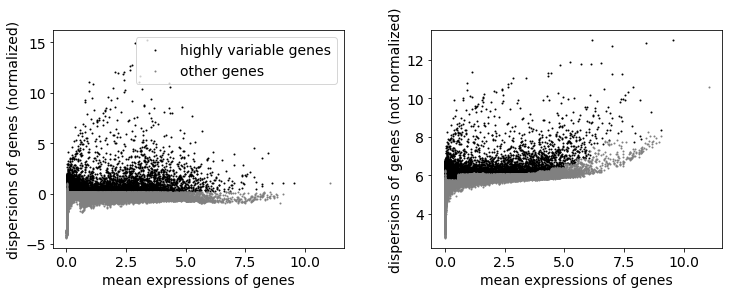

In [74]:
sc.pl.highly_variable_genes(adata)


In [75]:
np.count_nonzero(adata.var.highly_variable)

8531

In [76]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [81]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [82]:
sc.tl.pca(adata, svd_solver='arpack')

In [83]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen

In [84]:
sc.tl.umap(adata)

In [85]:
split = .8

idxs = np.arange(adata.shape[0])
np.random.shuffle(idxs)

idxs = idxs[:10000]

train_idxs = idxs[:int(split * idxs.shape[0])]
val_idxs = idxs[int(split * idxs.shape[0]):]

# X = np.copy(adata.X)

# X_train = X[train_idxs]
# X_val = X[val_idxs]

# y_train = adata.obs[cell_type_key][train_idxs]
# y_val = adata.obs[cell_type_key][train_idxs]
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [86]:
train_adata

AnnData object with n_obs × n_vars = 8000 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [87]:
val_adata

AnnData object with n_obs × n_vars = 2000 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [88]:
scg = scgen.VAEArith(x_dimension= train_adata.shape[1], model_path="/home/estorrs/pollock/models/vae_clf_test" )

In [89]:
%%time
history = scg.train(train_data=train_adata, use_validation=True, valid_data=val_adata, n_epochs=25,
                   verbose=True)

Epoch 0: Train Loss: 1733.88151171875    Valid Loss: 1719.1482504567791
Epoch 1: Train Loss: 1664.2892016601563    Valid Loss: 1682.783472861013
Epoch 2: Train Loss: 1637.564369140625    Valid Loss: 1662.1100148847027
Epoch 3: Train Loss: 1622.1002329101561    Valid Loss: 1656.5104941091229
Epoch 4: Train Loss: 1609.4602426757813    Valid Loss: 1643.911652595766
Epoch 5: Train Loss: 1597.7343588867188    Valid Loss: 1629.9893956338205
Epoch 6: Train Loss: 1589.0474477539062    Valid Loss: 1626.4618687783518
Epoch 7: Train Loss: 1581.269306640625    Valid Loss: 1623.9701459330897
Epoch 8: Train Loss: 1575.074896484375    Valid Loss: 1617.7045504662299
Epoch 9: Train Loss: 1569.4770629882812    Valid Loss: 1615.2838174143146
Epoch 10: Train Loss: 1564.336482421875    Valid Loss: 1610.628638482863
Epoch 11: Train Loss: 1558.4778666992188    Valid Loss: 1613.8465576171875
Epoch 12: Train Loss: 1553.18890234375    Valid Loss: 1612.5182514805947
Epoch 13: Train Loss: 1548.5281469726563    Va

In [90]:
train_embeddings = scg.to_latent(train_adata.X)
val_embeddings = scg.to_latent(val_adata.X)

In [91]:
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(np.asarray(train_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()
y_val = encoder.transform(np.asarray(val_adata.obs[cell_type_key]).reshape(-1, 1)).flatten()

In [92]:
clf = RandomForestClassifier()

In [93]:
%%time
clf.fit(train_embeddings, y_train)

CPU times: user 5.85 s, sys: 0 ns, total: 5.85 s
Wall time: 5.84 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
clf.score(train_embeddings, y_train)

1.0

In [95]:
clf.score(val_embeddings, y_val)

0.8825

In [96]:
from sklearn.metrics import confusion_matrix

In [97]:
preds = clf.predict(val_embeddings)

In [110]:
c_mat = confusion_matrix(y_val, preds)
c_mat = c_mat / np.sum(c_mat, axis=1).reshape(-1, 1)
c_mat = (c_mat * 100).astype(np.int32)

In [111]:
# c_mat / np.sum(c_mat, axis=0)

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

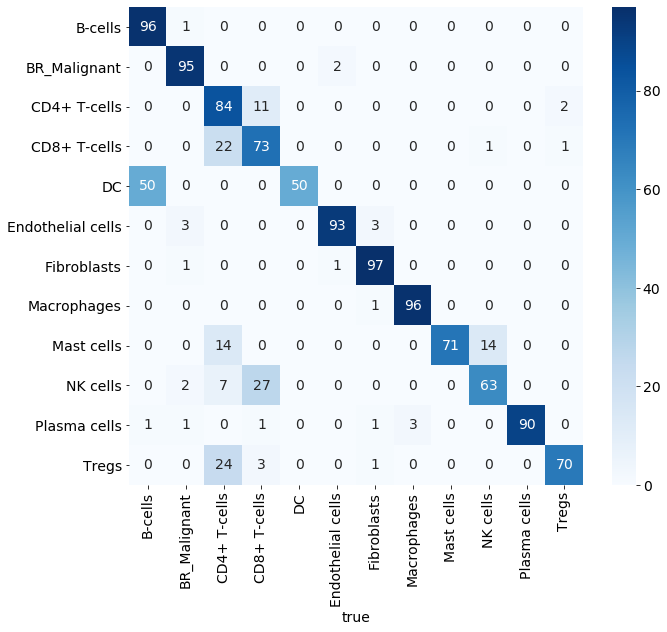

In [161]:
plt.figure(figsize=(10, 9))
sns.heatmap(c_mat, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0],
           cmap='Blues',  annot=True)
plt.xlabel('predicted')
plt.xlabel('true')
plt.tight_layout()
plt.savefig('br_confusion_matrix.pdf')

In [114]:
cell_embeddings = scg.to_latent(adata.X)
cell_embeddings

array([[-15.460298  ,   6.698204  ,  -4.272911  , ...,   3.6625807 ,
          6.625609  ,   3.048576  ],
       [-10.664401  ,   5.0957317 ,   4.3114486 , ..., -10.051421  ,
          3.397881  ,  12.919404  ],
       [ -3.622449  ,   4.752612  , -10.27097   , ...,   1.4240301 ,
          5.9787326 ,  -1.9284304 ],
       ...,
       [ -2.4918554 ,  -0.62477887,  -4.953066  , ...,   8.8302965 ,
          3.9895308 ,   0.3346357 ],
       [  5.9105763 ,  -0.25609165,   3.451879  , ...,  -7.0471    ,
          5.9785223 ,  10.358669  ],
       [  6.614931  ,   0.5689899 ,  -9.684477  , ...,  -4.8092613 ,
          1.6440891 ,   3.435534  ]], dtype=float32)

In [115]:
adata.obsm['scgen_embeddings'] = cell_embeddings
adata

AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'scgen_embeddings'
    varm: 'PCs'

In [123]:
predicted_cell_types = [encoder.categories_[0][int(i)] for i in clf.predict(cell_embeddings)]
adata.obs['predicted_cell_type'] = predicted_cell_types

In [116]:
import umap

In [117]:
adata.obsm['scgen_umap'] = umap.UMAP().fit_transform(adata.obsm['scgen_embeddings'])
adata

/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/scgen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/estorrs/miniconda3/envs/scgen/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/

AnnData object with n_obs × n_vars = 48280 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'scgen_embeddings', 'scgen_umap'
    varm: 'PCs'

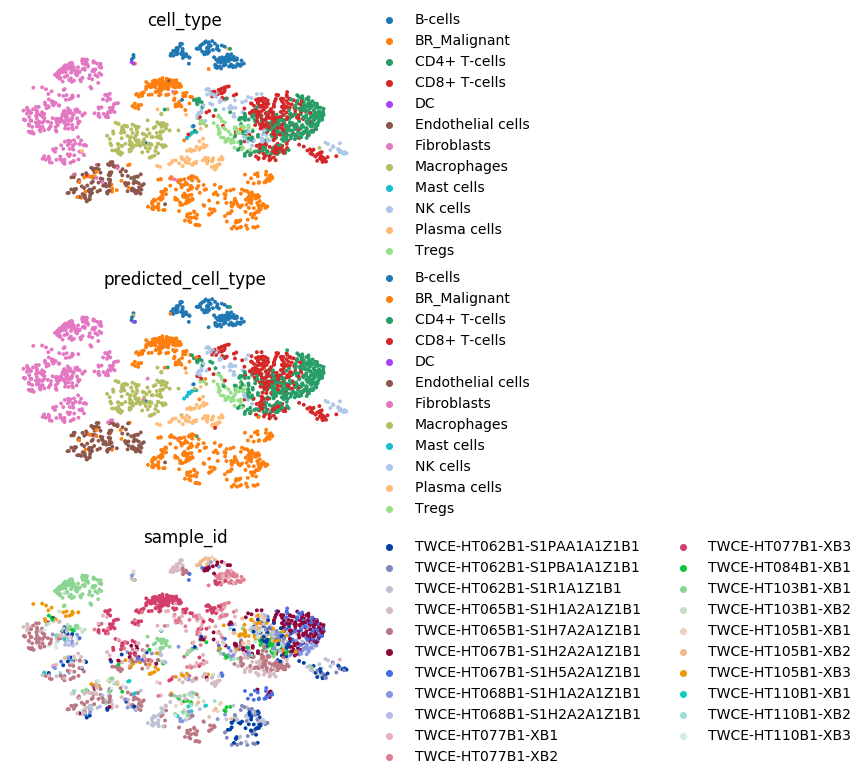

In [149]:
sc.pl.umap(adata[val_idxs], color=['cell_type', 'predicted_cell_type', 'sample_id'], frameon=False, ncols=1,
          save='_val_geneexp_umap.pdf')

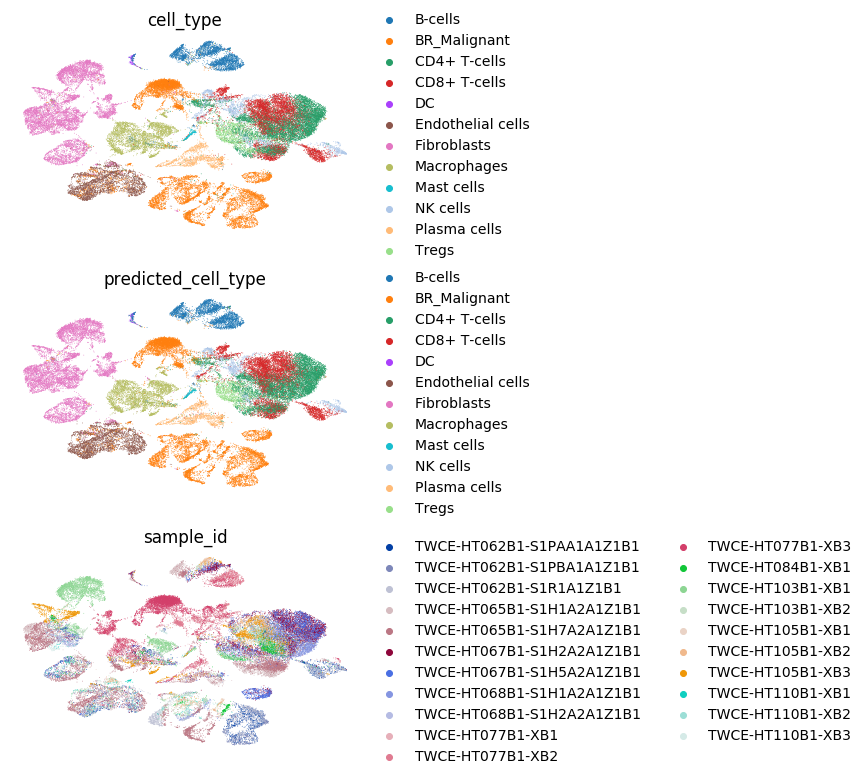

In [150]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'sample_id'], frameon=False, ncols=1,
          save='_all_geneexp_umap.pdf')

In [129]:
adata.obs['scgen_umap1'] = adata.obsm['scgen_umap'][:, 0]
adata.obs['scgen_umap2'] = adata.obsm['scgen_umap'][:, 1]

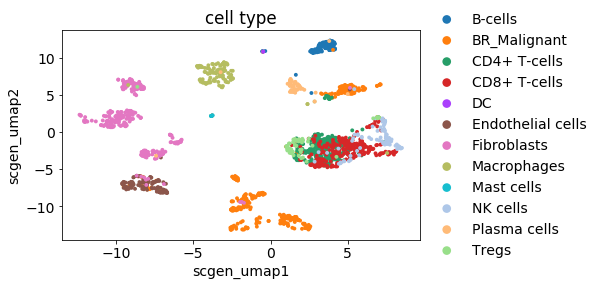

In [151]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='cell_type',
             frameon=False, save='_val_scgen_umap_groundtruth.pdf')

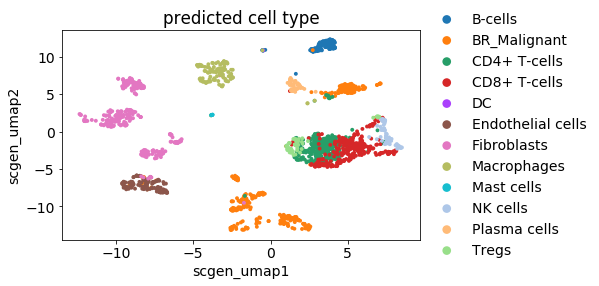

In [152]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='predicted_cell_type',
             frameon=False, save='_val_scgen_umap_predicted.pdf')

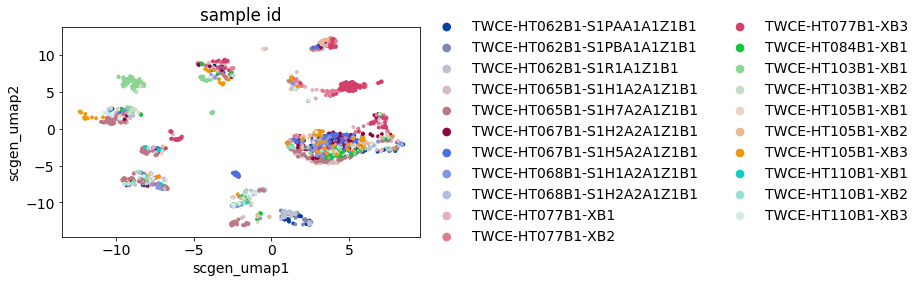

In [153]:
sc.pl.scatter(adata[val_idxs], x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False, save='_val_scgen_umap_sampleid.pdf')

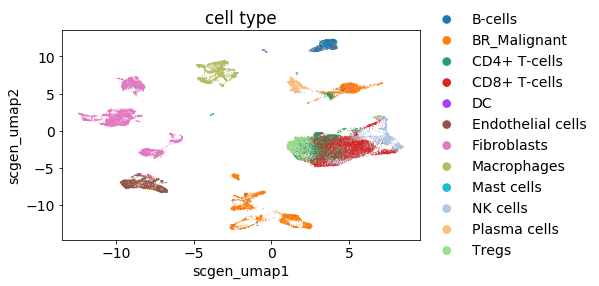

In [157]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='cell_type',
             frameon=False, save='_all_scgen_umap_groundtruth.pdf')

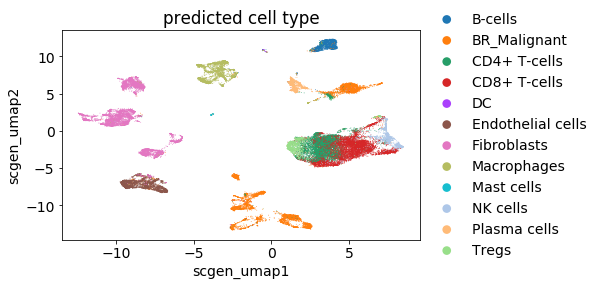

In [156]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='predicted_cell_type',
             frameon=False, save='_all_scgen_umap_predicted.pdf')

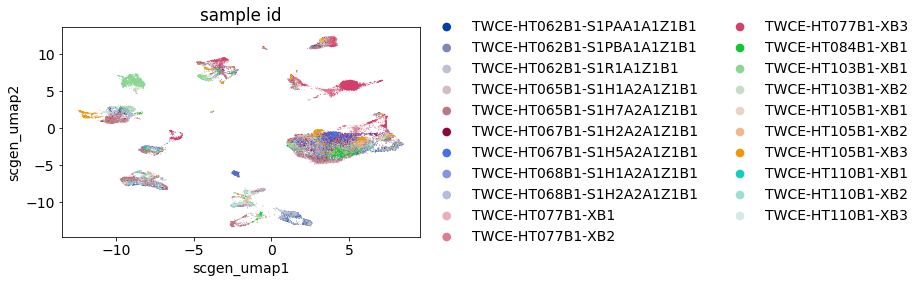

In [155]:
sc.pl.scatter(adata, x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False, save='_all_scgen_umap_sampleid.pdf')

In [145]:
tumor_adata = adata[adata.obs['cell_type']=='BR_Malignant'].copy()
tumor_adata

AnnData object with n_obs × n_vars = 10137 × 8531 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'predicted_cell_type', 'scgen_umap1', 'scgen_umap2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'predicted_cell_type_colors', 'sample_id_colors'
    obsm: 'X_pca', 'X_umap', 'scgen_embeddings', 'scgen_umap'
    varm: 'PCs'

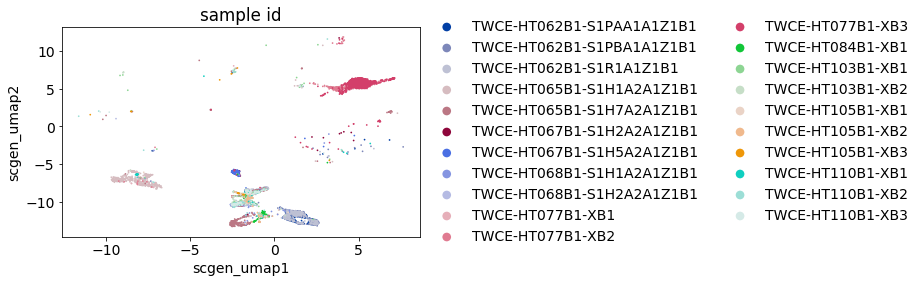

In [146]:
sc.pl.scatter(tumor_adata, x='scgen_umap1', y='scgen_umap2', color='sample_id',
             frameon=False)

In [23]:

train = sc.read("./tests/data/train_kang.h5ad",
                backup_url="https://goo.gl/33HtVh")
validation = sc.read("./tests/data/valid_kang.h5ad",
                     backup_url="https://goo.gl/8pdXiQ")

In [24]:
train

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [25]:
train.obs

,condition,n_counts,n_genes,mt_frac,cell_type
index,,,,,
AAACATACCAAGCT-1-stimulated,stimulated,1160.0,589,0.0,NK
AAACATACCCCTAC-1-stimulated,stimulated,1729.0,795,0.0,Dendritic
AAACATACCCGTAA-1-stimulated,stimulated,1360.0,585,0.0,CD4T
AAACATACCCTCGT-1-stimulated,stimulated,1442.0,732,0.0,B
AAACATACGAGGTG-1-stimulated,stimulated,1237.0,546,0.0,CD4T
...,...,...,...,...,...
TTTGACTGGCGGAA-1-control,control,2505.0,821,0.0,CD8T
TTTGACTGTCGTAG-1-control,control,3704.0,1101,0.0,CD14+Mono
TTTGACTGTTACCT-1-control,control,2133.0,629,0.0,CD14+Mono


In [26]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
validation_new = validation[~((validation.obs["cell_type"] == "CD4T") & (
    validation.obs["condition"] == "stimulated"))]

In [27]:
scg = scgen.VAEArith(x_dimension= train.shape[1], model_path="/home/estorrs/pollock/models/vae_test" )


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [28]:
scg.train(train_data=train_new, use_validation=True, valid_data=validation_new, n_epochs=10)

In [29]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]


In [30]:
pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"},
                          cell_type_key="cell_type",
                          condition_key="condition")

In [33]:
pred.shape

(2437, 6998)

In [32]:
delta

array([-8.5041428e-01,  7.5491285e-01,  7.1414309e+00,  1.6379387e+00,
        1.0854130e+00,  8.1711185e-01, -2.4481521e+00,  1.7262746e+00,
       -2.5781548e+00, -2.3019013e+00,  7.2806454e-01, -5.0180864e+00,
        1.1831952e+00,  1.6059554e+00,  6.3880239e+00,  2.4951282e+00,
       -5.2894431e-01,  3.6908561e-01, -1.4838127e+00, -2.7658358e-02,
        8.9996028e-01,  8.5127935e-02,  2.8785080e-02, -4.5098108e-01,
       -1.3649546e-01, -5.9999432e-02,  5.0323641e-01, -2.0177613e-01,
       -1.7653163e-01,  1.5224887e+00,  1.6287723e+00, -4.0245631e-01,
        3.4945824e+00, -5.5778229e-01,  1.0359895e+00, -1.6300678e-03,
        3.6535454e+00,  1.1418271e+00,  6.1919892e-01,  2.1394413e+00,
        2.5381446e-01, -1.0496867e-01, -6.4871287e-01, -1.8229173e+00,
        1.8114012e-02,  4.6955724e+00,  4.0130534e+00,  3.5009532e+00,
        5.6932459e+00, -1.2380776e+00, -9.8470521e-01,  2.0337541e+00,
        1.4026684e-01, -1.5703748e+00, -1.4709465e-01, -4.6585709e-02,
      

In [36]:
train_embeddings = scg.to_latent(train_new.X.toarray())
train_embeddings = scg.to_latent(train_new.X.toarray())

array([[ -4.486293  ,  -3.6660016 ,   4.669953  , ...,  -6.7957234 ,
          2.2941484 ,   5.6391478 ],
       [-10.039941  ,  -1.4098432 ,   8.323889  , ...,   1.1888855 ,
          2.5815823 ,  10.248201  ],
       [-13.911937  ,   0.59403896,  -0.3205298 , ...,  -3.530912  ,
         -2.9683695 ,   2.623416  ],
       ...,
       [ -9.292835  ,  -8.144408  ,   0.4678088 , ...,   0.86991274,
          3.1019385 ,  -1.4219899 ],
       [ -8.072471  ,  -3.1713877 ,  -4.856627  , ...,  -6.4134064 ,
          0.47653517,   4.1115165 ],
       [ -4.4804125 ,  -1.6973197 ,  -7.1387253 , ...,   4.548975  ,
         -0.22458856,   0.4275953 ]], dtype=float32)

<13766x6998 sparse matrix of type '<class 'numpy.float32'>'
	with 4577925 stored elements in Compressed Sparse Row format>

In [72]:
set(train_new.X[0].toarray().flatten())

{0.0,
 0.9476892,
 1.4253907,
 1.747324,
 1.990469,
 2.185906,
 2.3493207,
 2.489744,
 2.612855,
 2.9111083,
 2.9935746,
 3.2066462,
 4.5454707}